Train model on given data

## Import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.ensemble import IsolationForest
from kneed import KneeLocator

## Generate Data and Save

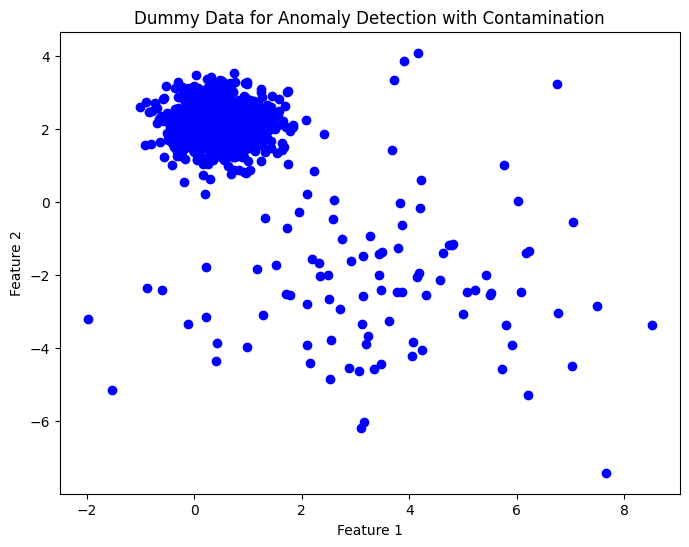

In [6]:
def generate_dummy_data(n_samples, contamination=0.1):
    # Generate normal data
    np.random.seed(0)
    normal_data, _ = make_blobs(n_samples=int(n_samples * (1 - contamination)), centers=1, cluster_std=0.5, center_box=(-5, 5))

    # Generate anomalies (contamination)
    anomaly_data, _ = make_blobs(n_samples=int(n_samples * contamination), centers=1, cluster_std=2, center_box=(-5, 5))

    # Combine normal and anomaly data
    data = np.vstack([normal_data, anomaly_data])

    # Shuffle the data
    np.random.shuffle(data)
    
    return data

# Example usage
data = generate_dummy_data(n_samples=1000, contamination=0.1)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c='b')
plt.title('Dummy Data for Anomaly Detection with Contamination')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [7]:
df = pd.DataFrame(data, columns=['column1','column2'])
df.to_csv("./../data/data.csv", index=False)

## Read data

In [8]:
input_file="./../data/data.csv"
df = pd.read_csv(input_file)
df.head()

,column1,column2
0,0.423082,2.198870
1,1.017649,1.640611
2,0.826866,2.177804
3,0.513612,1.254779
4,-0.252488,1.515615


## Feature Engineering

## Hyperparameter tuning

Preparation

e^-(X^2) is a function which maps 

0 to 1

-inf to 0

+inf to 0

In [44]:
def calculate_avg_anomaly_score(model, df_anomaly):
    anomaly_scores = model.decision_function(df_anomaly.values)
    avg_anomaly_score = np.mean(anomaly_scores)
    return avg_anomaly_score

def calculate_adv1_avg_anomaly_score(model, df_anomaly):
    anomaly_scores = model.decision_function(df_anomaly.values)
    avg_anomaly_score = np.e**(-(np.mean(anomaly_scores)-0.1)**2)
    return avg_anomaly_score

actual

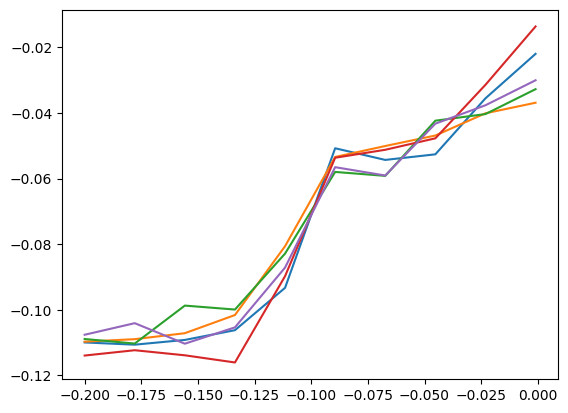

In [67]:
range_ = np.linspace(0.001,0.2,10)
knee_points = []

for random_number in [1,2,3,4,5]:
    avg_anomaly_scores = []
    for parameter in range_:
        model = IsolationForest(contamination=parameter,random_state=random_number)
        model.fit(df.values)
        outliers = model.predict(df.values)
        anomaly_indices = np.where(outliers == -1)[0]
        df_anomaly = df.iloc[anomaly_indices]
        avg_anomaly_scores.append(calculate_avg_anomaly_score(model, df_anomaly))
    knee_locator = KneeLocator(-range_, avg_anomaly_scores, curve='concave', direction='increasing')
    knee_point = knee_locator.knee
    knee_point = -knee_point
    knee_points.append(knee_point)
    plt.plot(-range_, avg_anomaly_scores)
plt.show()

In [68]:
knee_points

[0.001, 0.08944444444444445, 0.08944444444444445, 0.001, 0.08944444444444445]

In [80]:
knee_point = pd.Series(knee_points).value_counts().index[0]
knee_point

0.08944444444444445

## Final model

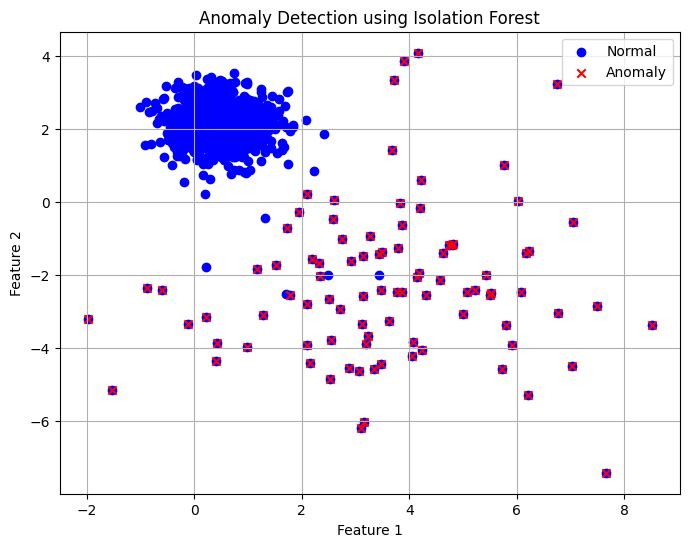

In [57]:
# Create and fit the Isolation Forest model
model = IsolationForest(contamination=knee_point)
model.fit(df.values)

# Predict outliers/anomalies
outliers = model.predict(df.values)

# Anomalies will be labeled as -1, normal points as 1
anomaly_indices = np.where(outliers == -1)[0]

# Visualize the data with anomalies highlighted
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], c='b', marker='o', label='Normal')
plt.scatter(data[anomaly_indices, 0], data[anomaly_indices, 1], c='r', marker='x', label='Anomaly')
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## Inference

In [58]:
#inference
given_point = [4,-4]
given_point = [np.array(given_point)]
model.predict(given_point)[0]

-1